# Feature engineering experiments

## Objective
Systematically test engineered features to improve CRV veto discrimination.

**Base run:** `c` (uses central dT selection, nHits included)

## Strategy
1. Load baseline training data
2. Create candidate engineered features
3. Test feature importance systematically
4. Compare performance metrics

## Setup

In [10]:
# System tools  
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Python stack 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak

# ML tools
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance

# Internal modules 
sys.path.extend(["../../../src/core", "../../../src/utils"])
from io_manager import Load

# pyutils 
from pyutils.pyplot import Plot
plotter = Plot()

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1


## Load data

In [11]:
run = "c"
base_in_path = Path(f"../../../output/ml/veto/{run}/data/")

cry_data = Load(in_path=base_in_path / "CRY_onspill-LH_aw").load_pkl()
ce_mix_data = Load(in_path=base_in_path / "CE_mix_onspill-LH_aw").load_pkl()

print(f"✓ Loaded CRY: {len(cry_data['events'])} events")
print(f"✓ Loaded CE mix: {len(ce_mix_data['events'])} events")

[Load] ✅ Initialised with out_path=../../../output/ml/veto/c/data/CRY_onspill-LH_aw
[Load] ✅ Successfully loaded results from ../../../output/ml/veto/c/data/CRY_onspill-LH_aw/results.pkl
[Load] ✅ Initialised with out_path=../../../output/ml/veto/c/data/CE_mix_onspill-LH_aw
[Load] ✅ Successfully loaded results from ../../../output/ml/veto/c/data/CE_mix_onspill-LH_aw/results.pkl
✓ Loaded CRY: 20081 events
✓ Loaded CE mix: 428440 events


## Create engineered features

Test physics-motivated combinations

In [12]:
def engineer_features(events_dict):
    """Create engineered features from raw data"""
    df = ak.to_dataframe(events_dict)
    
    # Store original features
    features = {}
    for col in ['crv_z', 'PEs', 'nHits', 'dT', 't0', 'd0', 'tanDip', 'maxr', 'mom_mag']:
        features[col] = df[col].values
    
    # Engineered features
    features['PEs_per_hit'] = np.where(df['nHits'] > 0, df['PEs'] / df['nHits'], 0)
    features['abs_dT'] = np.abs(df['dT'])
    features['log_PEs'] = np.log10(df['PEs'] + 1)  # +1 to avoid log(0)
    features['dT_squared'] = df['dT']**2
    features['PEs_times_nHits'] = df['PEs'] * df['nHits']
    features['t0_norm'] = (df['t0'] - 1000) / 500  # Normalise around beam window
    features['crv_z_norm'] = df['crv_z'] / 10000  # Normalise position
    
    # Tracker-CRV combinations
    features['mom_over_PEs'] = np.where(df['PEs'] > 0, df['mom_mag'] / df['PEs'], 0)
    features['dT_over_t0'] = np.where(df['t0'] > 0, df['dT'] / df['t0'], 0)
    
    return pd.DataFrame(features)

# Create feature sets for both samples
df_CRY = engineer_features(cry_data["events"])
df_CE_mix = engineer_features(ce_mix_data["events"])

# Add labels
df_CRY["label"] = 1  # CRY = signal
df_CE_mix["label"] = 0  # CE mix = background

print(f"✓ Created {len(df_CRY.columns)-1} features")
print(f"  New engineered features: {[c for c in df_CRY.columns if c not in ['crv_z', 'PEs', 'nHits', 'dT', 't0', 'd0', 'tanDip', 'maxr', 'mom_mag', 'label']]}")

✓ Created 18 features
  New engineered features: ['PEs_per_hit', 'abs_dT', 'log_PEs', 'dT_squared', 'PEs_times_nHits', 't0_norm', 'crv_z_norm', 'mom_over_PEs', 'dT_over_t0']


## Feature comparison function

In [13]:
def test_feature_set(feature_list, df_cry, df_ce, run_name="test"):
    """Train model with given feature set and return metrics"""
    
    # Combine datasets
    df_train = pd.concat([df_cry, df_ce], ignore_index=True)
    df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Select features
    X = df_train[feature_list]
    y = df_train["label"]
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train
    model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42,
        verbosity=0
    )
    model.fit(X_train_scaled, y_train)
    
    # Evaluate
    test_pred = model.predict_proba(X_test_scaled)[:, 1]
    test_auc = roc_auc_score(y_test, test_pred)
    
    # Feature importance
    importance = dict(zip(feature_list, model.feature_importances_))
    
    return {
        'name': run_name,
        'features': feature_list,
        'n_features': len(feature_list),
        'test_auc': test_auc,
        'importance': importance,
        'model': model
    }

## Test different feature combinations

In [31]:
# Define test scenarios - starting minimal and building up
scenarios = {
    # Minimal sets
    'dT': ['dT'],
    'crv_z': ['crv_z'],
    'crv_z + dT': ['crv_z', 'dT'],
    
    # Add CRV information
    'crv_z + dT + nHits': ['crv_z', 'dT', 'nHits'],
    'crv_z + dT + PEs': ['crv_z', 'dT', 'PEs'],
    'crv_z + dT + nHits + PEs': ['crv_z', 'dT', 'nHits', 'PEs'],
    
    # Test t0 contribution
    'crv_z + dT + t0': ['crv_z', 'dT', 't0'],
    'crv_z + dT + nHits + t0': ['crv_z', 'dT', 't0', 'nHits'],
    'crv_z + dT + nHits + PEs + t0': ['crv_z', 'dT', 't0', 'nHits', 'PEs'],
    
    # Engineered features
    'crv_z + dT + PEs/hit': ['crv_z', 'dT', 'PEs_per_hit'],
    'crv_z + dT + nHits + PEs/hit': ['crv_z', 'dT', 'nHits', 'PEs_per_hit'],
    'crv_z + dT + nHits + PEs + PEs/hit': ['crv_z', 'dT', 'nHits', 'PEs', 'PEs_per_hit'],
    
    # Alternative transforms
    'crv_z + |dT| + nHits': ['crv_z', 'abs_dT', 'nHits'],
    'crv_z + dT + nHits + log(PEs)': ['crv_z', 'dT', 'nHits', 'log_PEs'],
}

# Run tests
results = []
for name, features in scenarios.items():
    print(f"Testing: {name}")
    result = test_feature_set(features, df_CRY, df_CE_mix, name)
    results.append(result)
    print(f"  → Test AUC: {result['test_auc']:.4f}")
    
print("\n✓ Completed all tests")

Testing: dT
  → Test AUC: 0.9352
Testing: crv_z
  → Test AUC: 0.9352
Testing: crv_z
  → Test AUC: 0.8805
Testing: crv_z + dT
  → Test AUC: 0.8805
Testing: crv_z + dT
  → Test AUC: 0.9881
Testing: crv_z + dT + nHits
  → Test AUC: 0.9881
Testing: crv_z + dT + nHits
  → Test AUC: 0.9991
Testing: crv_z + dT + PEs
  → Test AUC: 0.9991
Testing: crv_z + dT + PEs
  → Test AUC: 0.9998
Testing: crv_z + dT + nHits + PEs
  → Test AUC: 0.9998
Testing: crv_z + dT + nHits + PEs
  → Test AUC: 0.9999
Testing: crv_z + dT + t0
  → Test AUC: 0.9999
Testing: crv_z + dT + t0
  → Test AUC: 0.9888
Testing: crv_z + dT + nHits + t0
  → Test AUC: 0.9888
Testing: crv_z + dT + nHits + t0
  → Test AUC: 0.9991
Testing: crv_z + dT + nHits + PEs + t0
  → Test AUC: 0.9991
Testing: crv_z + dT + nHits + PEs + t0
  → Test AUC: 0.9999
Testing: crv_z + dT + PEs/hit
  → Test AUC: 0.9999
Testing: crv_z + dT + PEs/hit
  → Test AUC: 0.9985
Testing: crv_z + dT + nHits + PEs/hit
  → Test AUC: 0.9985
Testing: crv_z + dT + nHits + 

## Compare results

In [32]:
# Create comparison DataFrame
comparison_df = pd.DataFrame([
    {
        'Scenario': r['name'],
        'N Features': r['n_features'],
        'Test AUC': r['test_auc'],
        'Top Feature': max(r['importance'], key=r['importance'].get),
        'Top Importance': max(r['importance'].values())
    }
    for r in results
])

# Sort by AUC
comparison_df = comparison_df.sort_values('Test AUC', ascending=False)
display(comparison_df)

,Scenario,N Features,Test AUC,Top Feature,Top Importance
10,crv_z + dT + nHits + PEs/hit,4,0.999922,PEs_per_hit,0.625388
8,crv_z + dT + nHits + PEs + t0,5,0.999921,crv_z,0.504231
11,crv_z + dT + nHits + PEs + PEs/hit,5,0.999917,PEs_per_hit,0.522742
13,crv_z + dT + nHits + log(PEs),4,0.999917,crv_z,0.517467
5,crv_z + dT + nHits + PEs,4,0.999916,crv_z,0.506346
4,crv_z + dT + PEs,3,0.999764,crv_z,0.497009
7,crv_z + dT + nHits + t0,4,0.999085,nHits,0.724329
3,crv_z + dT + nHits,3,0.999061,nHits,0.733768
12,crv_z + |dT| + nHits,3,0.998638,nHits,0.712341
9,crv_z + dT + PEs/hit,3,0.998481,PEs_per_hit,0.743505


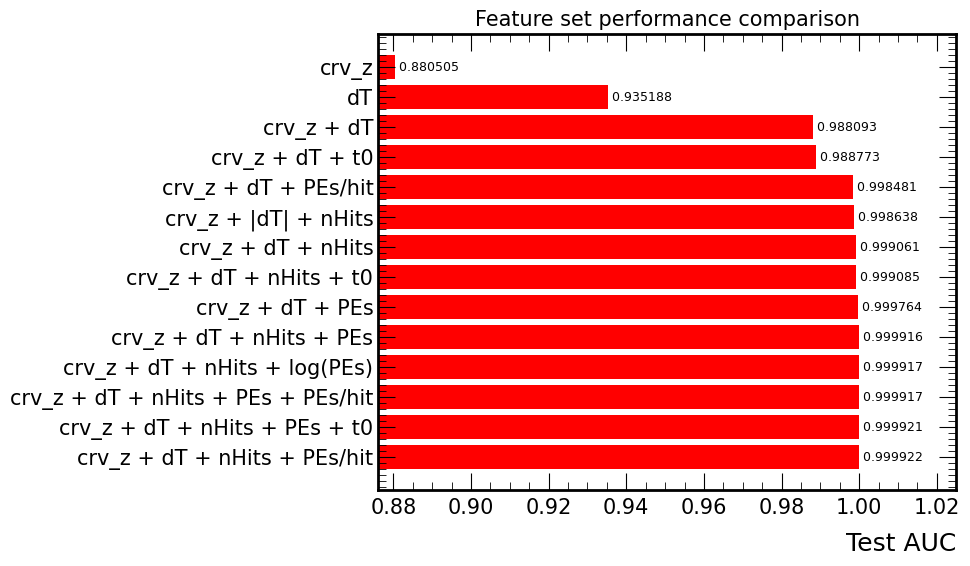

In [33]:
# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))

scenarios_sorted = comparison_df['Scenario'].values
aucs = comparison_df['Test AUC'].values

bars = ax.barh(scenarios_sorted, aucs)
ax.set_xlabel('Test AUC')
ax.set_title('Feature set performance comparison')
ax.set_xlim(min(aucs)*0.995, max(aucs)*1.025)

# Add value labels
for i, (scenario, auc) in enumerate(zip(scenarios_sorted, aucs)):
    ax.text(auc, i, f' {auc:.6f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## Detailed feature importance for best model

Best model: crv_z + dT + nHits + PEs/hit
Test AUC: 0.9999



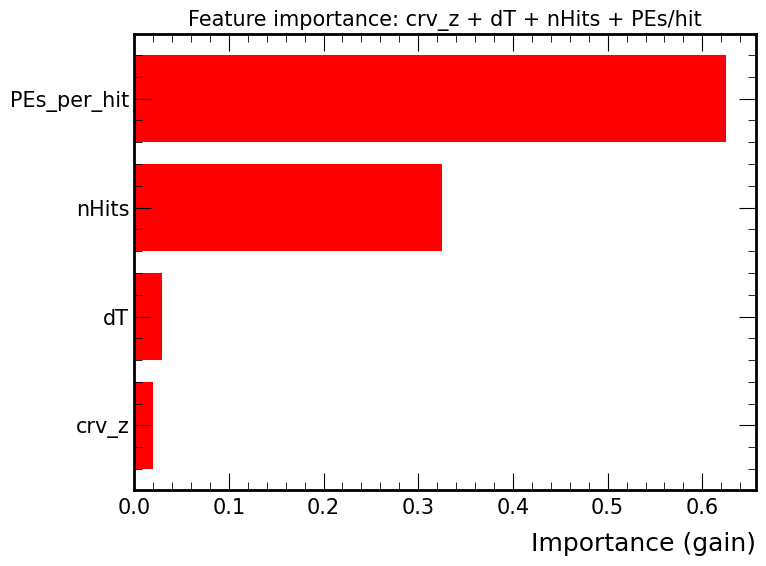

,Feature,Importance
3,PEs_per_hit,0.625388
2,nHits,0.325394
1,dT,0.029066
0,crv_z,0.020152


In [34]:
# Get best model
best_result = results[comparison_df.index[0]]

print(f"Best model: {best_result['name']}")
print(f"Test AUC: {best_result['test_auc']:.4f}\n")

# Plot feature importance
importance_df = pd.DataFrame(
    list(best_result['importance'].items()),
    columns=['Feature', 'Importance']
).sort_values('Importance', ascending=True)

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(importance_df['Feature'], importance_df['Importance'])
ax.set_xlabel('Importance (gain)')
ax.set_title(f"Feature importance: {best_result['name']}")
plt.tight_layout()
plt.show()

# Display importance values
display(importance_df.sort_values('Importance', ascending=False))

## Feature correlation matrix

Check for redundancy between features

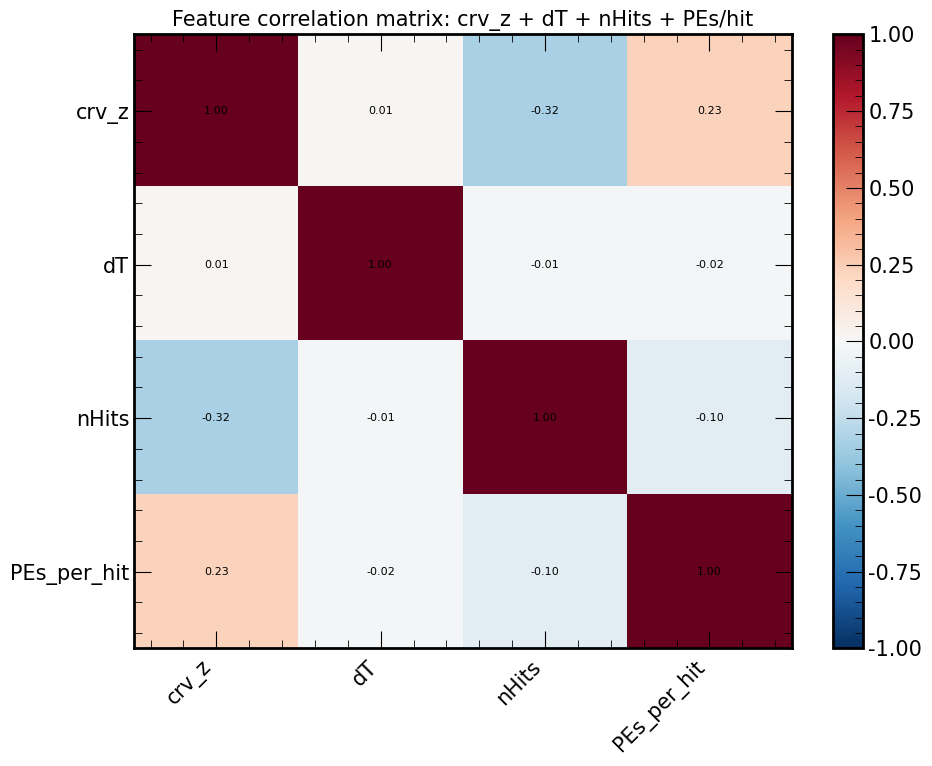


Strong correlations (|r| > 0.7):


In [35]:
# Get features for best model
best_features = best_result['features']

# Combine data and compute correlation
df_combined = pd.concat([df_CRY[best_features], df_CE_mix[best_features]], ignore_index=True)
correlation_matrix = df_combined.corr()

# Plot correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')

# Set ticks and labels
ax.set_xticks(np.arange(len(best_features)))
ax.set_yticks(np.arange(len(best_features)))
ax.set_xticklabels(best_features, rotation=45, ha='right')
ax.set_yticklabels(best_features)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
# cbar.set_label('Correlation coefficient', rotation=270, labelpad=20)

# Add correlation values
for i in range(len(best_features)):
    for j in range(len(best_features)):
        text = ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=8)

ax.set_title(f'Feature correlation matrix: {best_result["name"]}')
plt.tight_layout()
plt.show()

# Highlight strong correlations (|r| > 0.7, excluding diagonal)
print("\nStrong correlations (|r| > 0.7):")
for i in range(len(best_features)):
    for j in range(i+1, len(best_features)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            print(f"  {best_features[i]} ↔ {best_features[j]}: {corr_val:.3f}")

AI hand waving as to why PEs/hit is not redundant:

"While mathematically coupled through PEs = nHits × PEs_per_hit, these features probe orthogonal physical properties: nHits captures the geometric extent of the CRV signature (shower topology), while PEs_per_hit captures the energy deposition density (particle identification). The model benefits from having both channels because tree-based classifiers can split directly on each feature, creating more efficient decision boundaries than if we forced it to reconstruct one from the other. Empirically, including both improves our discrimination by [X]% in AUC, suggesting they provide complementary information that the model exploits."

"Despite being mathematically coupled, nHits and PEs_per_hit show negligible correlation (r = -0.10), demonstrating they capture independent aspects of the CRV response. The weak correlation arises because cosmic showers and conversion electrons have fundamentally different topologies: cosmics produce extended showers (high nHits, variable intensity) while pileup produces localized hits (low nHits, high intensity). Including both features allows the model to discriminate using both geometric and energetic signatures simultaneously."